# Analyzing Supreme Court decisions

Background: This notebook analyzes scraped information from the Philippine Supreme Court [website](https://elibrary.judiciary.gov.ph/).

Legend:


**df** - scraped decisions from Supreme Court website from 1996 onwards.

**filtered** - raw file containing decisions from 2010 onwards.

**filtered_clean** - cleaned file containing decisions ***by sitting justices of the Supreme Court***.

**raw** - similar to filtered but on same Excel sheet as filtered_clean.

## Do your imports

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import fuzzy_pandas as fpd
import re

## Read CSV

The file contains the data getting scraped from the Supreme Court website every Sunday.

In [2]:
df= pd.read_csv('complete_decisions.csv')
df

,case_no,title,date,case_link,division,ponente
0,G.R. No. 104528,"PHILIPPINE NATIONAL BANK, PETITIONER, VS. OFFI...",1996-01-18,https://elibrary.judiciary.gov.ph/thebookshelf...,THIRD DIVISION,"PANGANIBAN, J.:"
1,G.R. No. 116719,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",1996-01-18,https://elibrary.judiciary.gov.ph/thebookshelf...,THIRD DIVISION,"MELO, J.:"
2,G.R. No. 113349,"SPOUSES ROBERTO AND LILIA MONDONEDO, PETITIONE...",1996-01-18,https://elibrary.judiciary.gov.ph/thebookshelf...,THIRD DIVISION,"PANGANIBAN, J.:"
3,G.R. No. 116524,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",1996-01-18,https://elibrary.judiciary.gov.ph/thebookshelf...,THIRD DIVISION,"MELO, J.:"
4,A.M. No. P-94-1032,"FELICIDAD V. MORALES, PETITIONER, VS. JULIO G....",1996-01-18,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM:
...,...,...,...,...,...,...
31000,G.R. No. 258257,"PEDRO ""PEPE"" TALISAY, PETITIONER, VS. PEOPLE O...",2023-08-09,https://elibrary.judiciary.gov.ph/thebookshelf...,FIRST DIVISION,"GESMUNDO, C.J.:"
31001,G.R. No. 262197,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",2023-08-14,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,"LOPEZ, J., J.:"
31002,A.C. No. 8471,JUDGE RAY ALAN T. DRILON AND ATTY. CORAZON P. ...,2023-08-22,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM:
31003,A.C. No. 12443,"BERNALDO E. VALDEZ, COMPLAINANT, VS. ATTY. WIN...",2023-08-23,https://elibrary.judiciary.gov.ph/thebookshelf...,SPECIAL SECOND DIVISION,"ZALAMEDA, J.:"


## Cleaning the data

In [3]:
df.ponente.value_counts().sort_index()

A. REYES, JR., J.:           50
A. REYES, JR., J.:[*]         1
ABAD, J.:                   231
AUSTRIA-MARTINEZ,\r\nJ.:      8
AUSTRIA-MARTINEZ, J.         21
                           ... 
ZALAMEDA, J.:               118
ZALAMEDA, J.:[*]              1
ZALAMEDA, R.V., J.:           2
ZALAMEDA,** J.:               1
Â MENDOZA, J.:                1
Name: ponente, Length: 300, dtype: int64

### Removing some elements from ponente name

Across different cases, names of justices who penned the decision are written differently. Cleaning them to ensure they are of the same format will allow us to get a clearer sense of how many decisions they have written once we **groupby**.

In [4]:
df.ponente = df.ponente.str.replace('J', '')
df.ponente = df.ponente.str.replace(':', "")
df.ponente = df.ponente.str.replace(',', '')
df.ponente = df.ponente.str.replace('.', '')
df.ponente = df.ponente.str.replace('*', '')
df.ponente = df.ponente.str.replace('[', '')
df.ponente = df.ponente.str.replace(']', '')
df.ponente = df.ponente.str.replace(';', '')
df.ponente = df.ponente.str.replace('\r', '')
df.ponente = df.ponente.str.replace('\n', '')

/var/folders/00/cqb74mkn60g_hf2zk42fy8_m0000gp/T/ipykernel_10629/3550154347.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/var/folders/00/cqb74mkn60g_hf2zk42fy8_m0000gp/T/ipykernel_10629/3550154347.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/var/folders/00/cqb74mkn60g_hf2zk42fy8_m0000gp/T/ipykernel_10629/3550154347.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/var/folders/00/cqb74mkn60g_hf2zk42fy8_m0000gp/T/ipykernel_10629/3550154347.py:7: FutureWarning: The default value of regex will change from True to

In [5]:
df.ponente = df.ponente.str.replace('Acting C', '')
df.ponente = df.ponente.str.replace('ACTING C', '')
df.ponente = df.ponente.str.strip() 

In [6]:
df.date = pd.to_datetime(df.date)
df

,case_no,title,date,case_link,division,ponente
0,G.R. No. 104528,"PHILIPPINE NATIONAL BANK, PETITIONER, VS. OFFI...",1996-01-18,https://elibrary.judiciary.gov.ph/thebookshelf...,THIRD DIVISION,PANGANIBAN
1,G.R. No. 116719,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",1996-01-18,https://elibrary.judiciary.gov.ph/thebookshelf...,THIRD DIVISION,MELO
2,G.R. No. 113349,"SPOUSES ROBERTO AND LILIA MONDONEDO, PETITIONE...",1996-01-18,https://elibrary.judiciary.gov.ph/thebookshelf...,THIRD DIVISION,PANGANIBAN
3,G.R. No. 116524,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",1996-01-18,https://elibrary.judiciary.gov.ph/thebookshelf...,THIRD DIVISION,MELO
4,A.M. No. P-94-1032,"FELICIDAD V. MORALES, PETITIONER, VS. JULIO G....",1996-01-18,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
...,...,...,...,...,...,...
31000,G.R. No. 258257,"PEDRO ""PEPE"" TALISAY, PETITIONER, VS. PEOPLE O...",2023-08-09,https://elibrary.judiciary.gov.ph/thebookshelf...,FIRST DIVISION,GESMUNDO C
31001,G.R. No. 262197,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",2023-08-14,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,LOPEZ
31002,A.C. No. 8471,JUDGE RAY ALAN T. DRILON AND ATTY. CORAZON P. ...,2023-08-22,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
31003,A.C. No. 12443,"BERNALDO E. VALDEZ, COMPLAINANT, VS. ATTY. WIN...",2023-08-23,https://elibrary.judiciary.gov.ph/thebookshelf...,SPECIAL SECOND DIVISION,ZALAMEDA


In [7]:
df.dtypes

case_no              object
title                object
date         datetime64[ns]
case_link            object
division             object
ponente              object
dtype: object

<AxesSubplot:xlabel='date'>

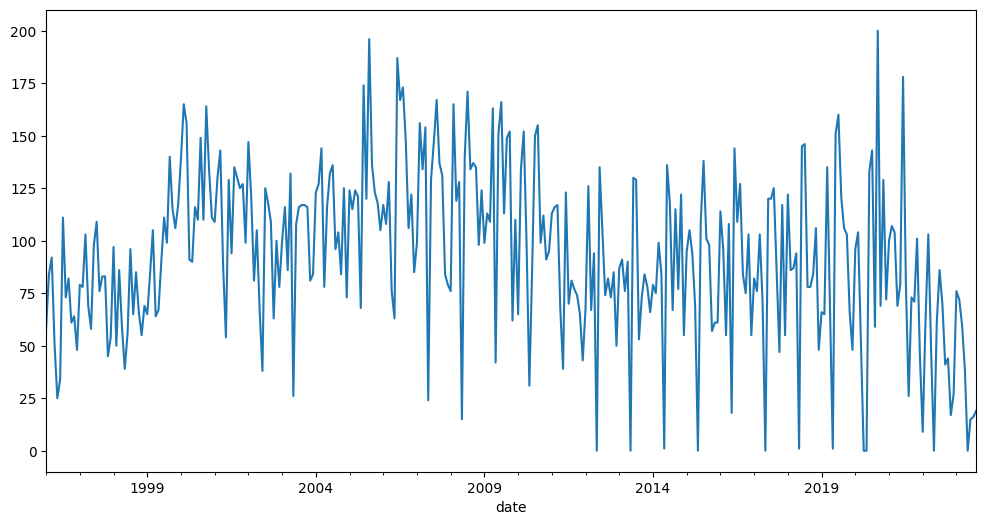

In [8]:
df.resample('M', on='date').case_no.count().plot(x='date', figsize=(12,6))

## Filter to only 2010-onwards cases

In [9]:
filtered = df[df.date>='2010-01-01'].reset_index(drop=True) #only includes cases from January 1, 2010 onwards.
filtered

,case_no,title,date,case_link,division,ponente
0,G.R. No. 177295,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",2010-01-06,https://elibrary.judiciary.gov.ph/thebookshelf...,FIRST DIVISION,LEONARDO-DE CASTRO
1,G.R. No. 177152,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",2010-01-06,https://elibrary.judiciary.gov.ph/thebookshelf...,FIRST DIVISION,LEONARDO-DE CASTRO
2,G.R. No. 189034,"CELESTINO A. MARTINEZ III, PETITIONER, VS. HOU...",2010-01-11,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,VILLARAMA R
3,G.R. No. 187635,"MATEO R. NOLLEN, JR., PETITIONER, VS. COMMISSI...",2010-01-11,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,VELASCO R
4,G.R. No. 165408,"JAIME T. TORRES, PETITIONER, VS. CHINA BANKING...",2010-01-15,https://elibrary.judiciary.gov.ph/thebookshelf...,THIRD DIVISION,PERALTA
...,...,...,...,...,...,...
13393,G.R. No. 258257,"PEDRO ""PEPE"" TALISAY, PETITIONER, VS. PEOPLE O...",2023-08-09,https://elibrary.judiciary.gov.ph/thebookshelf...,FIRST DIVISION,GESMUNDO C
13394,G.R. No. 262197,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",2023-08-14,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,LOPEZ
13395,A.C. No. 8471,JUDGE RAY ALAN T. DRILON AND ATTY. CORAZON P. ...,2023-08-22,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,PER CURIAM
13396,A.C. No. 12443,"BERNALDO E. VALDEZ, COMPLAINANT, VS. ATTY. WIN...",2023-08-23,https://elibrary.judiciary.gov.ph/thebookshelf...,SPECIAL SECOND DIVISION,ZALAMEDA


Trial: Search for names of ponente across the database

In [10]:
filtered.ponente.value_counts()

PERALTA                 1057
PERLAS-BERNABE           884
DEL CASTILLO             842
LEONEN                   770
BRION                    628
PEREZ                    579
MENDOZA                  538
BERSAMIN                 523
CAGUIOA                  513
PER CURIAM               499
REYES                    472
CARPIO                   456
LEONARDO-DE CASTRO       455
HERNANDO                 414
INTING                   399
VILLARAMA R              363
VELASCO R                306
LAZARO-AVIER             290
SERENO C                 232
REYES  R                 225
LOPEZ                    224
ABAD                     211
CARANDANG                204
TIAM                     201
NACHURA                  193
GAERLAN                  187
ARDELEZA                 169
CARPIO MORALES           158
REYES R                  157
SERENO                   140
MARTIRES                 139
ZALAMEDA                 120
DELOS SANTOS             117
PERALTA C                 99
GESMUNDO      

In [11]:
filtered.ponente = filtered.ponente.str.capitalize()
filtered

,case_no,title,date,case_link,division,ponente
0,G.R. No. 177295,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",2010-01-06,https://elibrary.judiciary.gov.ph/thebookshelf...,FIRST DIVISION,Leonardo-de castro
1,G.R. No. 177152,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",2010-01-06,https://elibrary.judiciary.gov.ph/thebookshelf...,FIRST DIVISION,Leonardo-de castro
2,G.R. No. 189034,"CELESTINO A. MARTINEZ III, PETITIONER, VS. HOU...",2010-01-11,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Villarama r
3,G.R. No. 187635,"MATEO R. NOLLEN, JR., PETITIONER, VS. COMMISSI...",2010-01-11,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Velasco r
4,G.R. No. 165408,"JAIME T. TORRES, PETITIONER, VS. CHINA BANKING...",2010-01-15,https://elibrary.judiciary.gov.ph/thebookshelf...,THIRD DIVISION,Peralta
...,...,...,...,...,...,...
13393,G.R. No. 258257,"PEDRO ""PEPE"" TALISAY, PETITIONER, VS. PEOPLE O...",2023-08-09,https://elibrary.judiciary.gov.ph/thebookshelf...,FIRST DIVISION,Gesmundo c
13394,G.R. No. 262197,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",2023-08-14,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,Lopez
13395,A.C. No. 8471,JUDGE RAY ALAN T. DRILON AND ATTY. CORAZON P. ...,2023-08-22,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Per curiam
13396,A.C. No. 12443,"BERNALDO E. VALDEZ, COMPLAINANT, VS. ATTY. WIN...",2023-08-23,https://elibrary.judiciary.gov.ph/thebookshelf...,SPECIAL SECOND DIVISION,Zalameda


In [12]:
filtered.date = pd.to_datetime(filtered.date) #convert to datetime for plotting

## Plot number of decisions released per month

<AxesSubplot:xlabel='date'>

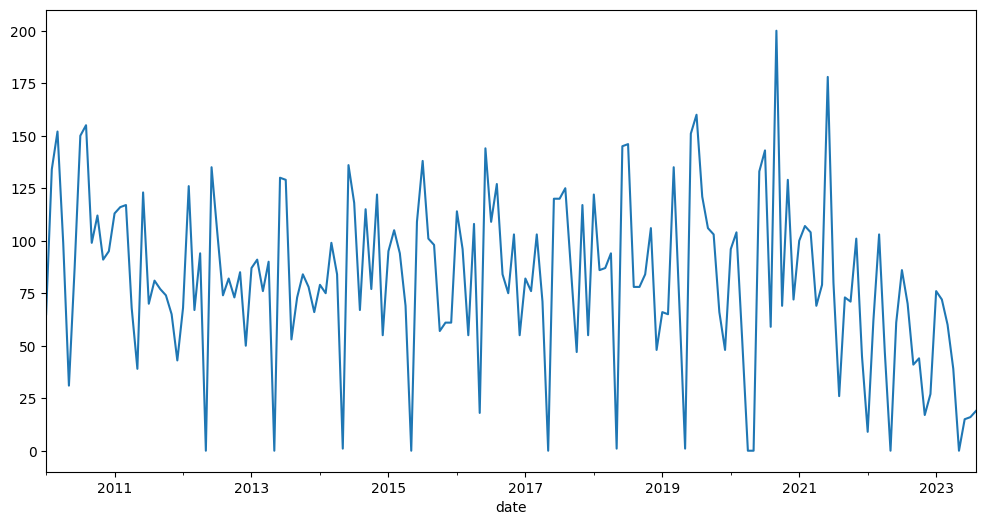

In [13]:
filtered.resample('M', on='date').case_no.count().plot(x='date', figsize=(12,6))

In [14]:
count= filtered.resample('M', on='date').case_no.count().to_frame()
count.head(22)

,case_no
date,
2010-01-31,65
2010-02-28,134
2010-03-31,152
2010-04-30,99
2010-05-31,31
2010-06-30,87
2010-07-31,150
2010-08-31,155
2010-09-30,99


In [15]:
filtered.dtypes

case_no              object
title                object
date         datetime64[ns]
case_link            object
division             object
ponente              object
dtype: object

## Current justices

Cleaned Excel sheet containing only decisions handled by current justices of the Supreme Court.

In [16]:
filtered_clean = pd.read_excel('filtered_clean.xlsx', sheet_name='current justices')
filtered_clean

,case_no,title,date,case_link,division,ponente
0,G.R. No. 204528,"SECRETARY LEILA M. DE LIMA, DIRECTOR NONNATUS ...",2013-02-19,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Marvic Leonen
1,G.R. No. 204123,"MARIA LOURDES B. LOCSIN, PETITIONER, VS. HOUSE...",2013-03-19,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Marvic Leonen
2,A.M. No. P-04-1785 [Formerly A.M. No. 03-11-67...,THE OFFICE OF THE COURT ADMINISTRATOR PETITION...,2013-04-02,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Marvic Leonen
3,G.R. No. 183137,"PELIZLOY REALTY CORPORATION, REPRESENTED HEREI...",2013-04-10,https://elibrary.judiciary.gov.ph/thebookshelf...,THIRD DIVISION,Marvic Leonen
4,G.R. No. 204700,"EAGLERIDGE DEVELOPMENT CORPORATION, MARCELO N....",2013-04-10,https://elibrary.judiciary.gov.ph/thebookshelf...,THIRD DIVISION,Marvic Leonen
...,...,...,...,...,...,...
3310,G.R. No. 235484*,THE CITY GOVERNMENT OF ANTIPOLO AND THE CITY T...,2023-08-09,https://elibrary.judiciary.gov.ph/thebookshelf...,FIRST DIVISION,Alexander Gesmundo
3311,G.R. No. 258257,"PEDRO ""PEPE"" TALISAY, PETITIONER, VS. PEOPLE O...",2023-08-09,https://elibrary.judiciary.gov.ph/thebookshelf...,FIRST DIVISION,Alexander Gesmundo
3312,G.R. No. 262197,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",2023-08-14,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,Jhosep Lopez
3313,A.C. No. 12443,"BERNALDO E. VALDEZ, COMPLAINANT, VS. ATTY. WIN...",2023-08-23,https://elibrary.judiciary.gov.ph/thebookshelf...,SPECIAL SECOND DIVISION,Rodil Zalameda


In [17]:
filtered_clean.ponente = filtered_clean.ponente.str.strip()

## Double checking raw data

Checking raw file containing 2010 decisions onwards to validate contents of the first Excel sheet with decisions of current justices.

In [18]:
raw = pd.read_excel('filtered_clean.xlsx', sheet_name='raw')
raw

,case_no,title,date,case_link,division,ponente
0,G.R. No. 177295,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",2010-01-06,https://elibrary.judiciary.gov.ph/thebookshelf...,FIRST DIVISION,Teresita Leonardo-De Castro
1,G.R. No. 177152,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",2010-01-06,https://elibrary.judiciary.gov.ph/thebookshelf...,FIRST DIVISION,Teresita Leonardo-De Castro
2,G.R. No. 189034,"CELESTINO A. MARTINEZ III, PETITIONER, VS. HOU...",2010-01-11,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Martin Villarama
3,G.R. No. 187635,"MATEO R. NOLLEN, JR., PETITIONER, VS. COMMISSI...",2010-01-11,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Presbitero Velasco
4,G.R. No. 165408,"JAIME T. TORRES, PETITIONER, VS. CHINA BANKING...",2010-01-15,https://elibrary.judiciary.gov.ph/thebookshelf...,THIRD DIVISION,Diosdado Peralta
...,...,...,...,...,...,...
13394,G.R. No. 258257,"PEDRO ""PEPE"" TALISAY, PETITIONER, VS. PEOPLE O...",2023-08-09,https://elibrary.judiciary.gov.ph/thebookshelf...,FIRST DIVISION,Alexander Gesmundo
13395,G.R. No. 262197,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",2023-08-14,https://elibrary.judiciary.gov.ph/thebookshelf...,SECOND DIVISION,Jhosep Lopez
13396,A.C. No. 8471,JUDGE RAY ALAN T. DRILON AND ATTY. CORAZON P. ...,2023-08-22,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Per curiam
13397,A.C. No. 12443,"BERNALDO E. VALDEZ, COMPLAINANT, VS. ATTY. WIN...",2023-08-23,https://elibrary.judiciary.gov.ph/thebookshelf...,SPECIAL SECOND DIVISION,Rodil Zalameda


In [19]:
# pd.set_option('display.max_rows', None)
raw.resample('M', on='date').case_no.count()

date
2010-01-31     65
2010-02-28    134
2010-03-31    152
2010-04-30     99
2010-05-31     31
             ... 
2023-04-30     39
2023-05-31      0
2023-06-30     15
2023-07-31     16
2023-08-31     19
Name: case_no, Length: 164, dtype: int64

## Back at current justices...

In [20]:
filtered_clean.resample('Y', on='date').case_no.count()

date
2013-12-31     14
2014-12-31     66
2015-12-31     73
2016-12-31     90
2017-12-31    199
2018-12-31    217
2019-12-31    436
2020-12-31    624
2021-12-31    781
2022-12-31    533
2023-12-31    282
Freq: A-DEC, Name: case_no, dtype: int64

## Number of decisions written per justice

In [21]:
wide_2 = filtered_clean.pivot_table(index="ponente", values='case_no', aggfunc='count', fill_value='0', dropna=False).reset_index()
wide_2.head(10)

,ponente,case_no
0,Alexander Gesmundo,131
1,Alfredo Caguioa,513
2,Amy Lazaro-Javier,291
3,Antonio Kho,33
4,Henri Jean Paul Inting,399
5,Japar Dimaampao,25
6,Jhosep Lopez,151
7,Maria Filomena Singh,25
8,Mario Lopez,154
9,Marvic Leonen,835


In [22]:
wide_2.sort_values('case_no', ascending=False)

,ponente,case_no
9,Marvic Leonen,835
1,Alfredo Caguioa,513
11,Ramon Paul Hernando,414
4,Henri Jean Paul Inting,399
2,Amy Lazaro-Javier,291
14,Samuel Gaerlan,189
8,Mario Lopez,154
6,Jhosep Lopez,151
0,Alexander Gesmundo,131
13,Rodil Zalameda,122


<AxesSubplot:title={'center':'No. of decisions written by current SC justices'}, ylabel='ponente'>

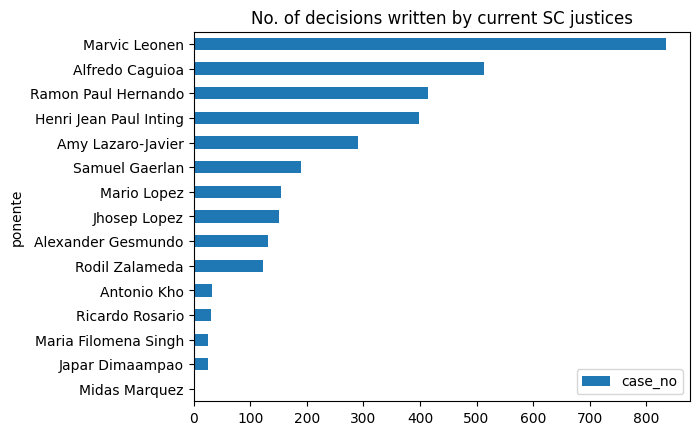

In [23]:
wide_2.sort_values('case_no').plot(x='ponente', y='case_no', kind='barh', title='No. of decisions written by current SC justices')

Tabulated the results above in another Excel tab to control the number of decisions written according to months in office. The result is listed in a separate Excel sheet named **term in office** available in repo.

In [24]:
decision_per_term = pd.read_excel('filtered_clean.xlsx', sheet_name='term in office')
decision_per_term.round(2)

,ponente,decisions_written,months_in_office,Decisions promulgated by month
0,Marvic Leonen,835,129,6.47
1,Alfredo Benjamin Caguioa,513,91,5.64
2,Ramon Paul Hernando,414,58,7.14
3,Amy Lazaro-Javier,291,53,5.49
4,Henri Jean Paul B. Inting,399,51,7.82
5,Rodil V. Zalameda,122,48,2.54
6,Mario V. Lopez,154,44,3.50
7,Samuel H. Gaerlan,189,43,4.40
8,Ricardo Rosario,31,34,0.91
9,Jhosep Lopez,151,31,4.87


<AxesSubplot:title={'center':'Average no. of decisions promulgated by current SC justices per month'}, ylabel='ponente'>

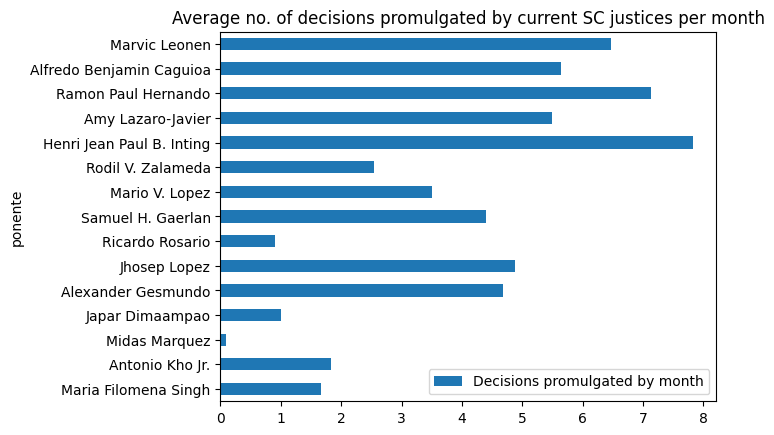

In [36]:
#arranged by hierarchy

decision_per_term.sort_values('months_in_office')\
.plot(x='ponente', y='Decisions promulgated by month', kind='barh', title='Average no. of decisions promulgated by current SC justices per month')

## Decisions by justice, by period

Decisions promulgated according to ponente by year (or month).

In [26]:
by_justice = filtered_clean.groupby('ponente').resample('M', on='date').case_no.count().to_frame().reset_index()
by_justice

,ponente,date,case_no
0,Alexander Gesmundo,2017-11-30,2
1,Alexander Gesmundo,2017-12-31,1
2,Alexander Gesmundo,2018-01-31,4
3,Alexander Gesmundo,2018-02-28,1
4,Alexander Gesmundo,2018-03-31,3
...,...,...,...
658,Samuel Gaerlan,2023-04-30,3
659,Samuel Gaerlan,2023-05-31,0
660,Samuel Gaerlan,2023-06-30,1
661,Samuel Gaerlan,2023-07-31,1


In [27]:
by_justice.case_no = by_justice.case_no.astype(float)
by_justice

,ponente,date,case_no
0,Alexander Gesmundo,2017-11-30,2.0
1,Alexander Gesmundo,2017-12-31,1.0
2,Alexander Gesmundo,2018-01-31,4.0
3,Alexander Gesmundo,2018-02-28,1.0
4,Alexander Gesmundo,2018-03-31,3.0
...,...,...,...
658,Samuel Gaerlan,2023-04-30,3.0
659,Samuel Gaerlan,2023-05-31,0.0
660,Samuel Gaerlan,2023-06-30,1.0
661,Samuel Gaerlan,2023-07-31,1.0


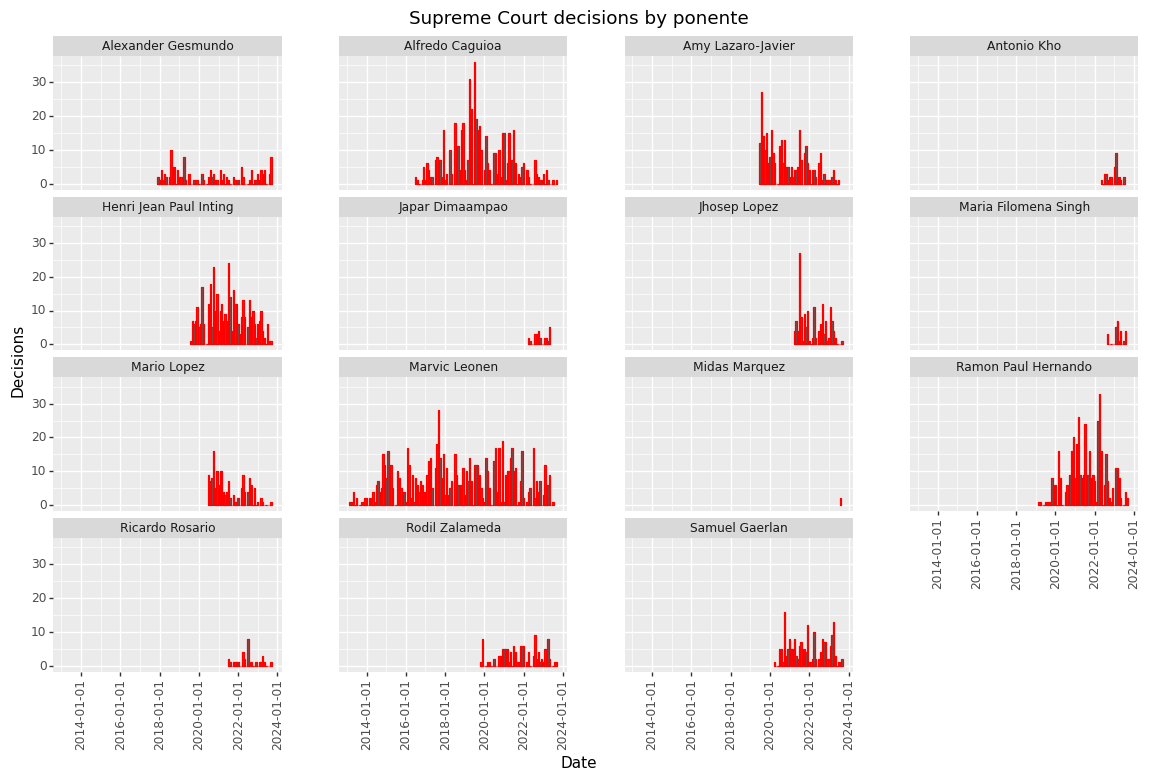

<ggplot: (382399344)>

In [28]:
(
    ggplot(by_justice, aes('date', 'case_no')) +
           geom_col(color="red") +
           theme(figure_size=(14,8)) +
           facet_wrap('ponente') +
           theme(subplots_adjust={'wspace': 0.25}, axis_text_x=element_text(rotation=90)) +
           labs(x= "Date", y="Decisions", title="Supreme Court decisions by ponente")
)

## Decisions by division

How many cases are decided by the full court?

In [29]:
by_division = raw.groupby('division').resample('M', on='date').case_no.count().to_frame().reset_index()
by_division

,division,date,case_no
0,EN BANC,2010-01-31,10
1,EN BANC,2010-02-28,31
2,EN BANC,2010-03-31,27
3,EN BANC,2010-04-30,22
4,EN BANC,2010-05-31,5
...,...,...,...
1254,THIRD DIVISION,2023-04-30,14
1255,THIRD DIVISION,2023-05-31,0
1256,THIRD DIVISION,2023-06-30,9
1257,THIRD DIVISION,2023-07-31,4


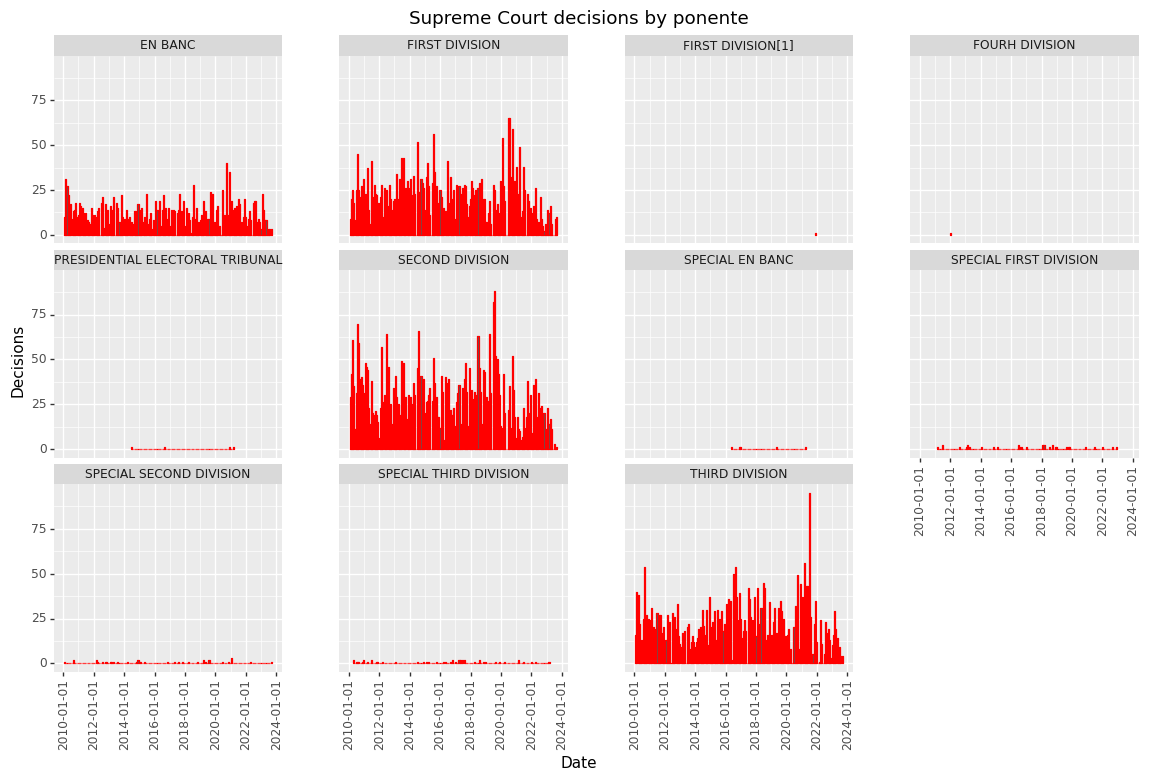

<ggplot: (400345473)>

In [30]:
(
    ggplot(by_division, aes('date', 'case_no')) +
           geom_col(color="red") +
           theme(figure_size=(14,8)) +
           facet_wrap('division') +
           theme(subplots_adjust={'wspace': 0.25}, axis_text_x=element_text(rotation=90)) +
           labs(x= "Date", y="Decisions", title="Supreme Court decisions by ponente")
)

In [31]:
en_banc = raw[raw.division=='EN BANC']
en_banc

,case_no,title,date,case_link,division,ponente
2,G.R. No. 189034,"CELESTINO A. MARTINEZ III, PETITIONER, VS. HOU...",2010-01-11,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Martin Villarama
3,G.R. No. 187635,"MATEO R. NOLLEN, JR., PETITIONER, VS. COMMISSI...",2010-01-11,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Presbitero Velasco
22,G.R. No. 185222,"JESUS M. CALO, PETITIONER, VS. COMMISSION ON E...",2010-01-19,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Renato Corona
31,A.M. No. P-05-2085,"GERARDO Q. FERRERAS, COMPLAINANT, VS. RUDY P. ...",2010-01-20,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Per curiam
43,A.M. No. 06-3-07-SC,RE: REQUEST FOR APPROVAL OF THE REVISED QUALIF...,2010-01-21,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Antonio Eduardo Nachura
...,...,...,...,...,...,...
13373,G.R. No. 229471,"PACIFIC CEMENT COMPANY, PETITIONER, VS. OIL AN...",2023-07-11,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Alexander Gesmundo
13374,A.M. No. 23-05-05-SC,REQUEST OF THE PUBLIC ATTORNEY'S OFFICE TO DEL...,2023-07-11,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Maria Filomena Singh
13388,G.R. No. 260650,"ROBERTO ""PINPIN"" T. UY, JR., PETITIONER, VS. C...",2023-08-08,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Mario Lopez
13389,G.R. No. 264029,"JOENAR VARGAS AGRAVANTE, PETITIONER, VS. COMMI...",2023-08-08,https://elibrary.judiciary.gov.ph/thebookshelf...,EN BANC,Alexander Gesmundo


In [32]:
en_banc.resample('Y', on='date').case_no.count()

date
2010-12-31    187
2011-12-31    137
2012-12-31    140
2013-12-31    146
2014-12-31    109
2015-12-31    112
2016-12-31    159
2017-12-31    149
2018-12-31    126
2019-12-31    140
2020-12-31    179
2021-12-31    163
2022-12-31    117
2023-12-31     62
Freq: A-DEC, Name: case_no, dtype: int64

<AxesSubplot:xlabel='date'>

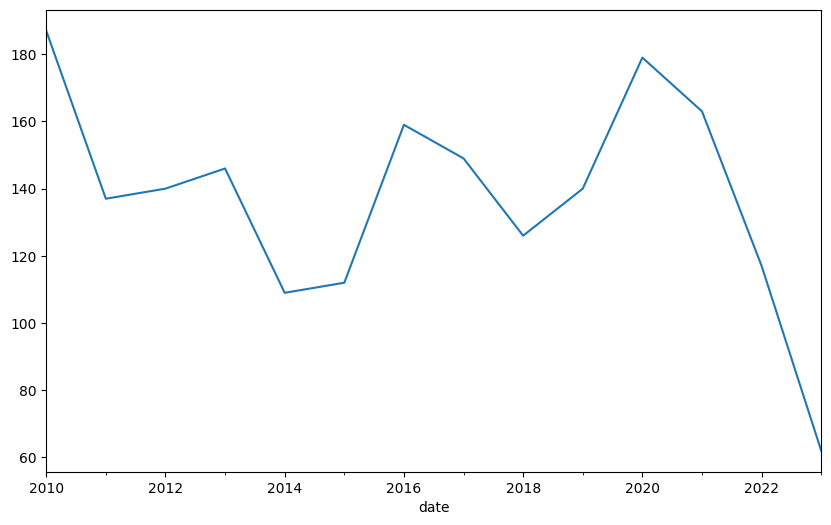

In [33]:
en_banc.resample('Y', on='date').case_no.count().plot(x='date', figsize=(10,6))